In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp

from environment import Env, validate_against_hint, load_word_lists, construct_word_df


In [2]:
df = construct_word_df(*load_word_lists())

In [3]:


def construct_state_tensor(guesses, history):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(history.max(axis=0) == 2)

        green_chars = [guesses[x][y] for x,y in np.argwhere(history == 2) ]
        orange_chars = [guesses[x][y] for x,y in np.argwhere(history == 1) ]
        black_chars = [guesses[x][y] for x,y in np.argwhere(history == 0) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))
        num_black_letters = len(set(black_chars))

        sequence_number = int(history.size / 5)
        #print(f'construct_state() with seqno {sequence_number}')

        sequence_number_onehot = np.zeros(Env.num_guesses)
        sequence_number_onehot[sequence_number] = 1.0
        arr = np.concatenate((np.array([num_green_locs, num_other_letters, num_black_letters])/5, sequence_number_onehot))
        return torch.tensor(arr, device=device, dtype=torch.float)
        

    

The aim here is to use a NN to represent the policy, rather than the value function.  We will shrink the action space (ie, so that we have a few actions, rather than 12000).  This will remove the model's ability to learn novel strategies, rather it will just be learning when to employ the different strategies (actions) that I give it.  Start w
ith these 3 word selection tactics:

1. choose words which match the current history
1. choose words which contain the greatest number of new letters
1. choose words which have the highest frequency score

then we will construct 6 actions by choosing every possible order of these strategies
1. 1,2,3
1. 1,3,2
1. 2,1,3
1. 2,3,1
1. 3,1,2
1. 3,2,1

for all these actions there may be multiple words, so sample a random one.  The policy then becomes a logistic regressor which selects one of these actions to execute.  The loss to train the regressor will be derived using the policy gradiet theorem.


In [4]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count, permutations

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [6]:
class PolicyNetNN(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 20)
        self.head = nn.Linear(20, num_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        return F.softmax(self.head(x), dim=0)

In [51]:
class PolicyNetLinear(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetLinear, self).__init__()
        self.head = nn.Linear(num_inputs, num_actions)
        #print(f'PolicyNetLinear {num_inputs}, {num_actions}')

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        return F.softmax(self.head(x), dim=0)
    
class PolicyMonteCarlo(nn.Module):
    def __init__(self, num_guesses, num_actions):
        super(PolicyMonteCarlo, self).__init__()
        self.weights = torch.nn.Parameter(torch.rand((num_guesses, num_actions), dtype=float), requires_grad=True)
        #self.weights.require_grad = True
        self.x = torch.Tensor([1.0,1.0])
        
    def forward(self, state):
        onehot = state[3:]
        step_idx = torch.argmax(onehot, dim=0)
        
        y = F.softmax(self.x.mul(self.weights[step_idx]), dim=0)
        #print(f'onehot {onehot}, step_idx {step_idx}')
        #print(self.weights)
        #print(self.weights[step_idx])
        #print(y)
        return y
    
class PolicyAvgReward():
    def __init__(self, num_guesses, num_actions):
        self.weights = torch.Tensor([[.5,.5],[1,0],[1,0],[1,0],[1,0],[1,0]])
        self.reward_stats = [(defaultdict(int),defaultdict(int)) for _ in range(num_guesses)]
        
        
    def __call__(self, state):
        onehot = state[3:]
        step_idx = torch.argmax(onehot, dim=0)
        if step_idx == 0:
            return F.softmax(self.weights[step_idx], dim=0)
        else:
            return self.weights[step_idx]
    
    def calc_avgs(self):
        for action in (0,1):
            if self.reward_stats[0][action]['count'] > 0:
                self.weights[0][action] = self.reward_stats[0][action]['total'] / self.reward_stats[0][action]['count']
        

In [8]:
#define the word-selection tactics
n_state_features = 9

class PolicyHelper:
    def __init__(self, env):
        self.env = env
        self.actions = [[env.find_target_words, env.find_words_matching_current_history]]
        self.actions.append([env.find_words_with_highest_new_letter_freq_score])
                
        self.num_actions = len(self.actions)
        #self.net = PolicyNetLinear(n_state_features, len(self.actions))
        
    def perform_action(self, action_idx):
        tactic_tuple = self.actions[action_idx]
        df = self.env.df
        for tactic in tactic_tuple: # apply all the tactics in the given order
            newdf = tactic(df)
            if not newdf.empty: #if that tactic produced no results, then quit
                df = newdf
        return df.sample()['word'][0] # then pick a random word from what is left
    
    

In [9]:





def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    if len(vals) >= window_width:
        cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(np.insert(ma_vec, 0, [None]*int(window_width/2)))

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses, epsilons, gammas):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    if epsilons: plot_values(epsilons, axes=['epsilon', 'step'])
    if gammas: plot_values(gammas, axes=['gamma', 'step'])
    #plt.ioff()
    plt.show()

In [42]:
def optimize_model_batch(model, optimizer, memory, batch_size=128):
    transitions = memory.sample(batch_size)

    losses = [optimize_model_single(model, optimizer, tr.state, tr.action, tr.reward) for tr in transitions]
    
    return losses

def optimize_model_single(model, optimizer, state, action, reward):
    
    if isinstance(model, PolicyAvgReward):
        onehot = state[3:]
        step_idx = torch.argmax(onehot, dim=0)
        model.reward_stats[step_idx][action]['count'] += 1
        model.reward_stats[step_idx][action]['total'] += reward
        model.calc_avgs()
        return reward
    # calculate gradient
    probs = model(state)
    sampler = Categorical(probs)
    #print(f'sampler {sampler}')
    log_probs = -sampler.log_prob(action)   # "-" because it was built to work with gradient descent, but we are using gradient ascent

    pseudo_loss = log_probs * reward # loss that when differentiated with autograd gives the gradient of J(θ)
    #print(f'log_prob {log_probs}, reward {reward}, loss {pseudo_loss} ')
    # update policy weights
    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()

    return pseudo_loss


class TrainConfig():
    def __init__(self, optimizer='adam', batch_size=64, train_interval=64, clear_memory=False, lr=0.01):
        self.optimizer = optimizer
        self.clear_memory = clear_memory
        self.lr = lr
        self.train_interval = train_interval
        self.batch_size = batch_size
        
class ValueConfig():
    def __init__(self, name='reward', gamma=[0.9, 0.05, 200]):
        self.name = name
        self.gamma = gamma
        
class ModelConfig():
    def __init__(self, name='naive', startword=None, target_list_only=None):
        self.name = name
        self.startword = startword
        self.target_list_only = target_list_only

In [49]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model=ModelConfig(name='naive', startword=None, target_list_only=False),
                   num_episodes=128,
                   eps=[0.9, 0.05, 200],
                   value_function=ValueConfig(name='reward',gamma=[0.0, 1.0, 200]),
                   training=TrainConfig(),
                   seed=0):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    GAMMA_START, GAMMA_END, GAMMA_DECAY = value_function.gamma
    env = Env(df)
    memory = ReplayMemory(10000)
    starting_state = construct_state_tensor(env.guesses, env.history)

    steps_done = 0
    last_training = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    epsilons = []
    gammas = []
    reward_stats = [(defaultdict(int),defaultdict(int)) for _ in range(env.num_guesses)]
    
    policy_helper = PolicyHelper(env)
    
    if model.name == 'linear':
        policy_net = PolicyNetLinear(n_state_features, len(policy_helper.actions)).to(device)
    elif model.name == 'monte':
        policy_net = PolicyMonteCarlo(env.num_guesses, len(policy_helper.actions)).to(device)
        print('monte weights')
        print(policy_net.weights)
        print(F.softmax(policy_net.weights, dim=1))
    elif model.name == 'avg_reward':
        policy_net = PolicyAvgReward(env.num_guesses, len(policy_helper.actions))
    else:
        policy_net = PolicyNetNN(n_state_features, len(policy_helper.actions)).to(device)
    
    if model.name == 'avg_reward':
        optimizer = None
    elif training.optimizer == 'rmsprop':
            optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)
    elif training.optimizer == 'sgd':
            optimizer = optim.SGD(policy_net.parameters(), lr=training.lr)
    else:
            optimizer = optim.Adam(policy_net.parameters(), lr=training.lr)

        #print(f'pn params {list(policy_net.parameters())}')
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        state = starting_state
        guesses = []
        for t in count():
            GAMMA = GAMMA_END + (GAMMA_START - GAMMA_END) * math.exp(-1. * steps_done / GAMMA_DECAY)
            gammas.append(GAMMA)
            steps_done += 1
            # Select and perform an action
            #print(state, actions)
            probs = policy_net(state)
            sampler = Categorical(probs)
            action_idx = sampler.sample()
            chosen_word = policy_helper.perform_action(action_idx)
            guesses.append(chosen_word)
            print(f'------guess {t} {action_idx} {guesses[-1]}-------')
            history, reward, done = env.step(chosen_word)
            #here next_state == env.history
            if not done:
                next_state = construct_state_tensor(guesses, history)
            
            #action_tensor = action_idx.clone().detach()
            action = action_idx #F.one_hot(action_idx, num_classes=policy_helper.num_actions)
                
            print(f'reward {reward} done {done} action {action}')
            #reward = np.array([reward])

            # Store the transition in memory
            #memory.push(state, action_idx, reward)
            episode_memory.append([state, action, reward])
            # Move to the next state
            state = next_state

            if done:
                episode_durations.append(t + 1)
                episode_reward = sum([tr[2] for tr in episode_memory])
                print(f'episode {i_episode} finished.  reward {episode_reward}  eps {eps}  gamma {GAMMA}  steps {steps_done}  memory {len(memory)}')
                episode_rewards.append(episode_reward)
                
                for idx,tr in enumerate(episode_memory):
                    #print(f'pushing episode_reward {episode_reward} {episode_reward.__class__}')
                    memory.push(tr[0], tr[1], episode_reward)
                    #loss = optimize_model_single(policy_net, optimizer, tr[0], tr[1], episode_reward)
                    #losses.append(loss)
                
                    reward_stats[idx][tr[1]]['count'] += 1
                    reward_stats[idx][tr[1]]['total'] += episode_reward
                    episode_reward -= tr[2]
                    
                    
                # If we have gathered enough data, Perform one step of the optimization (on the policy network)
                if len(memory) >= training.batch_size \
                    and steps_done % training.train_interval == 0:
                    losses += optimize_model_batch(policy_net, optimizer, memory, batch_size=training.batch_size)
                    if training.clear_memory: memory.clear()
                        
                    if model.name == 'monte':
                        print('monte weights')
                        print(policy_net.weights)
                        print(F.softmax(policy_net.weights, dim=1))
                        for rs in reward_stats:
                            rs[0]['avg'] = rs[0]['total'] / rs[0]['count']
                            rs[1]['avg'] = rs[1]['total'] / rs[1]['count']
                            print(dict(rs[0]), dict(rs[1]))
                    elif model.name == 'avg_reward':
                        print('monte weights')
                        print(policy_net.weights)
                        print(F.softmax(policy_net.weights, dim=1))
                        
                
                #plot_durations()
                break

    print('Complete')
    
    
    return episode_durations, episode_rewards, losses, epsilons, gammas

#env.render()
#env.close()
#plt.ioff()
#plt.show()

=========================episode 0 nanny======================
------guess 0 0 spied-------
reward -1 done False action 0
------guess 1 0 manly-------
reward -1 done False action 0
------guess 2 0 fanny-------
reward -1 done False action 0
------guess 3 0 canny-------
reward -1 done False action 0
------guess 4 0 nanny-------
reward 0 done True action 0
episode 0 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.019801326693244747  steps 5  memory 0
=========================episode 1 essay======================
------guess 0 0 again-------
reward -1 done False action 0
------guess 1 0 broad-------
reward -1 done False action 0
------guess 2 0 sweat-------
reward -1 done False action 0
------guess 3 0 essay-------
reward 0 done True action 0
episode 1 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.03921056084767682  steps 9  memory 5
=========================episode 2 liken======================
------guess 0 0 alibi-------
reward -1 done False action 0
------guess 1 0 devil-----

------guess 4 0 flume-------
reward 0 done True action 0
episode 19 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.3462302148701527  steps 86  memory 49
=========================episode 20 mammy======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 badly-------
reward -1 done False action 0
------guess 2 0 savvy-------
reward -1 done False action 0
------guess 3 0 wacky-------
reward -1 done False action 0
------guess 4 0 fanny-------
reward -1 done False action 0
------guess 5 0 happy-------
reward -1 done True action 0
episode 20 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.3655520320517718  steps 92  memory 54
=========================episode 21 debut======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 quite-------
reward -1 done False action 0
------guess 2 0 debut-------
reward 0 done True action 0
episode 21 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.3749977317172992  step

------guess 4 0 billy-------
reward -1 done False action 0
------guess 5 0 dilly-------
reward -1 done True action 0
episode 40 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.5682894765709203  steps 169  memory 131
=========================episode 41 macro======================
------guess 0 0 piece-------
reward -1 done False action 0
------guess 1 0 comma-------
reward -1 done False action 0
------guess 2 0 macho-------
reward -1 done False action 0
------guess 3 0 macro-------
reward 0 done True action 0
episode 41 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.5768379176822511  steps 173  memory 137
=========================episode 42 locus======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 soggy-------
reward -1 done False action 0
------guess 2 0 bosom-------
reward -1 done False action 0
------guess 3 0 focus-------
reward -1 done False action 0
------guess 4 0 locus-------
reward 0 done True action 0
episode 42 finished.  

------guess 2 0 thief-------
reward 0 done True action 0
episode 61 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7205690317785927  steps 256  memory 29
monte weights
tensor([[-3.1818, -3.7778],
        [ 1.0000,  0.0000],
        [ 1.0000,  0.0000],
        [ 1.0000,  0.0000],
        [ 1.0000,  0.0000],
        [ 1.0000,  0.0000]])
tensor([[0.6447, 0.3553],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.7311, 0.2689]])
=========================episode 62 shore======================
------guess 0 0 flack-------
reward -1 done False action 0
------guess 1 0 prime-------
reward -1 done False action 0
------guess 2 0 store-------
reward -1 done False action 0
------guess 3 0 swore-------
reward -1 done False action 0
------guess 4 0 snore-------
reward -1 done False action 0
------guess 5 0 shore-------
reward 0 done True action 0
episode 62 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.7288274649544001  step

------guess 2 0 aloft-------
reward -1 done False action 0
------guess 3 0 about-------
reward 0 done True action 0
episode 80 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.812691820518043  steps 336  memory 44
=========================episode 81 sixth======================
------guess 0 0 alter-------
reward -1 done False action 0
------guess 1 0 ghost-------
reward -1 done False action 0
------guess 2 0 smith-------
reward -1 done False action 0
------guess 3 0 sixth-------
reward 0 done True action 0
episode 81 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8164007709722821  steps 340  memory 48
=========================episode 82 plane======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 lease-------
reward -1 done False action 0
------guess 2 0 blade-------
reward -1 done False action 0
------guess 3 0 flame-------
reward -1 done False action 0
------guess 4 0 plane-------
reward 0 done True action 0
episode 82 finished.  rewa

------guess 2 0 yearn-------
reward 0 done True action 0
episode 102 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8799683714885432  steps 425  memory 38
=========================episode 103 swing======================
------guess 0 0 spiky-------
reward -1 done False action 0
------guess 1 0 swish-------
reward -1 done False action 0
------guess 2 0 swill-------
reward -1 done False action 0
------guess 3 0 swift-------
reward -1 done False action 0
------guess 4 0 swine-------
reward -1 done False action 0
------guess 5 0 swing-------
reward 0 done True action 0
episode 103 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.883515842226503  steps 431  memory 41
=========================episode 104 score======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 force-------
reward -1 done False action 0
------guess 2 0 score-------
reward 0 done True action 0
episode 104 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8852500654027212 

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 parry-------
reward -1 done False action 0
------guess 2 0 hardy-------
reward 0 done True action 0
episode 125 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9230808185581655  steps 514  memory 127
=========================episode 126 amaze======================
------guess 0 0 flail-------
reward -1 done False action 0
------guess 1 0 abase-------
reward -1 done False action 0
------guess 2 0 agate-------
reward -1 done False action 0
------guess 3 0 amaze-------
reward 0 done True action 0
episode 126 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9246039203988723  steps 518  memory 130
=========================episode 127 awoke======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 awoke-------
reward 0 done True action 0
episode 127 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9253541239255645  steps 520  memory 134
=========================episode 

------guess 1 0 jelly-------
reward -1 done False action 0
------guess 2 0 spell-------
reward -1 done False action 0
------guess 3 0 swell-------
reward 0 done True action 0
episode 146 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.950212931632136  steps 601  memory 53
=========================episode 147 repay======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 regal-------
reward -1 done False action 0
------guess 2 0 repay-------
reward 0 done True action 0
episode 147 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9509541645129833  steps 604  memory 57
=========================episode 148 plain======================
------guess 0 0 radio-------
reward -1 done False action 0
------guess 1 0 await-------
reward -1 done False action 0
------guess 2 0 quail-------
reward -1 done False action 0
------guess 3 0 slain-------
reward -1 done False action 0
------guess 4 0 plain-------
reward 0 done True action 0
episode 148 finished. 

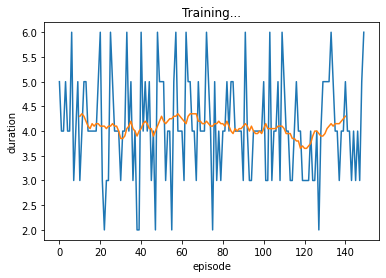

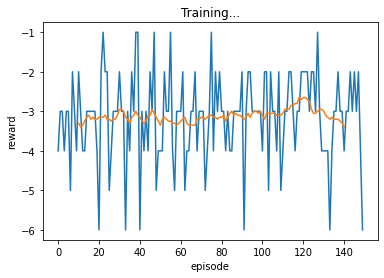

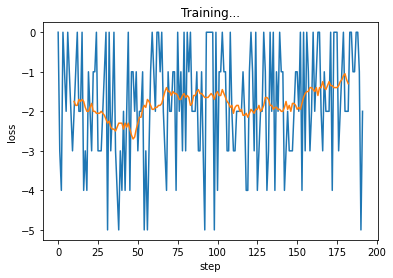

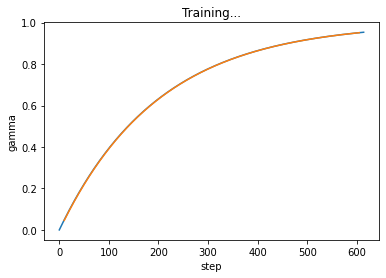

In [52]:
plot_all(*run_experiment(
    model=ModelConfig(name='avg_reward'),
    num_episodes=150,
    training=TrainConfig(optimizer='sgd', lr=0.01, batch_size=32, train_interval=32, clear_memory=True),
    seed=1
    ))

monte weights
Parameter containing:
tensor([[0.0611, 0.2246],
        [0.2343, 0.1771],
        [0.5561, 0.1094],
        [0.4609, 0.7084],
        [0.5798, 0.4967],
        [0.5104, 0.3295]], dtype=torch.float64, requires_grad=True)
tensor([[0.4592, 0.5408],
        [0.5143, 0.4857],
        [0.6098, 0.3902],
        [0.4385, 0.5615],
        [0.5208, 0.4792],
        [0.5451, 0.4549]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
pn params [Parameter containing:
tensor([[0.0611, 0.2246],
        [0.2343, 0.1771],
        [0.5561, 0.1094],
        [0.4609, 0.7084],
        [0.5798, 0.4967],
        [0.5104, 0.3295]], dtype=torch.float64, requires_grad=True)]
=========================episode 0 nanny======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 gaudy-------
reward -1 done False action 0
------guess 2 0 balmy-------
reward -1 done False action 0
------guess 3 0 happy-------
reward -1 done False action 0
------guess 4 1 snick-------
r

------guess 2 0 skill-------
reward 0 done True action 0
episode 17 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.33965971929501715  steps 84  memory 81
=========================episode 18 otter======================
------guess 0 0 allow-------
reward -1 done False action 0
------guess 1 1 tries-------
reward -1 done False action 1
------guess 2 1 cundy-------
reward -1 done False action 1
------guess 3 1 bumph-------
reward -1 done False action 1
------guess 4 1 fungi-------
reward -1 done False action 1
------guess 5 0 otter-------
reward 0 done True action 0
episode 18 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.35917572396768127  steps 90  memory 84
=========================episode 19 glory======================
------guess 0 0 shove-------
reward -1 done False action 0
------guess 1 1 trail-------
reward -1 done False action 1
------guess 2 1 cundy-------
reward -1 done False action 1
------guess 3 1 gimps-------
reward -1 done False action 1
------guess 4 0 glory--

------guess 4 0 loyal-------
reward 0 done True action 0
episode 36 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.5747168089177259  steps 172  memory 167
=========================episode 37 drool======================
------guess 0 0 snoop-------
reward -1 done False action 0
------guess 1 0 brood-------
reward -1 done False action 0
------guess 2 0 drool-------
reward 0 done True action 0
episode 37 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.581048450752361  steps 175  memory 172
=========================episode 38 safer======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 swear-------
reward -1 done False action 0
------guess 3 0 safer-------
reward 0 done True action 0
episode 38 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.5893442472476544  steps 179  memory 175
=========================episode 39 chair======================
------guess 0 0 scale-------
rewar

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 gloss-------
reward -1 done False action 0
------guess 2 0 bingo-------
reward -1 done False action 0
------guess 3 0 owing-------
reward 0 done True action 0
episode 55 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7315256767607634  steps 264  memory 260
=========================episode 56 serif======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 serif-------
reward 0 done True action 0
episode 56 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.735522738700176  steps 267  memory 264
=========================episode 57 using======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 swill-------
reward -1 done False action 0
------guess 2 0 using-------
reward 0 done True action 0
episode 57 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7394602921400244  st

------guess 5 0 tease-------
reward 0 done True action 0
episode 71 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8154804760070107  steps 339  memory 13
=========================episode 72 curve======================
------guess 0 0 spray-------
reward -1 done False action 0
------guess 1 1 teloi-------
reward -1 done False action 1
------guess 2 0 curve-------
reward 0 done True action 0
episode 72 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8182276138246325  steps 342  memory 19
=========================episode 73 showy======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 showy-------
reward 0 done True action 0
episode 73 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8209338520885068  steps 345  memory 22
=========================episode 74 sleek======================
------guess 0 0 assay-------
reward -1 done False action 0
------guess 1 1 reoil-------
reward 

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 druid-------
reward 0 done True action 0
episode 91 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8817554096233645  steps 428  memory 104
=========================episode 92 flask======================
------guess 0 0 truly-------
reward -1 done False action 0
------guess 1 1 aeons-------
reward -1 done False action 1
------guess 2 0 basil-------
reward -1 done False action 0
------guess 3 0 slack-------
reward -1 done False action 0
------guess 4 0 flask-------
reward 0 done True action 0
episode 92 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8846748789619375  steps 433  memory 108
=========================episode 93 idiom======================
------guess 0 0 clamp-------
reward -1 done False action 0
------guess 1 1 roset-------
reward -1 done False action 1
------guess 2 0 idiom

------guess 5 0 crier-------
reward 0 done True action 0
episode 109 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9230808185581655  steps 514  memory 188
=========================episode 110 wound======================
------guess 0 0 vague-------
reward -1 done False action 0
------guess 1 1 lirot-------
reward -1 done False action 1
------guess 2 0 mound-------
reward -1 done False action 0
------guess 3 1 psych-------
reward -1 done False action 1
------guess 4 0 wound-------
reward 0 done True action 0
episode 110 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9249799599146731  steps 519  memory 194
=========================episode 111 peace======================
------guess 0 0 tonga-------
reward -1 done False action 0
------guess 1 1 liers-------
reward -1 done False action 1
------guess 2 1 duchy-------
reward -1 done False action 1
------guess 3 0 peace-------
reward 0 done True action 0
episode 111 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.92646545623694

------guess 2 0 alpha-------
reward -1 done False action 0
------guess 3 1 mucid-------
reward -1 done False action 1
------guess 4 1 befog-------
reward -1 done False action 1
------guess 5 0 caulk-------
reward 0 done True action 0
episode 127 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9479213394240343  steps 592  memory 42
=========================episode 128 alive======================
------guess 0 0 teach-------
reward -1 done False action 0
------guess 1 1 loris-------
reward -1 done False action 1
------guess 2 1 gundy-------
reward -1 done False action 1
------guess 3 0 alike-------
reward -1 done False action 0
------guess 4 0 alive-------
reward 0 done True action 0
episode 128 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9492071661351015  steps 597  memory 48
=========================episode 129 gourd======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 for

------guess 1 1 rotal-------
reward -1 done False action 1
------guess 2 1 psych-------
reward -1 done False action 1
------guess 3 1 gamed-------
reward -1 done False action 1
------guess 4 0 fleck-------
reward 0 done True action 0
episode 145 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9667931799180093  steps 682  memory 133
=========================episode 146 rover======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 roger-------
reward -1 done False action 0
------guess 4 0 rower-------
reward -1 done False action 0
------guess 5 0 rover-------
reward 0 done True action 0
episode 146 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9677745897680832  steps 688  memory 138
=========================episode 147 slice======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 l

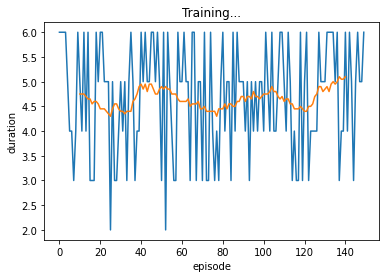

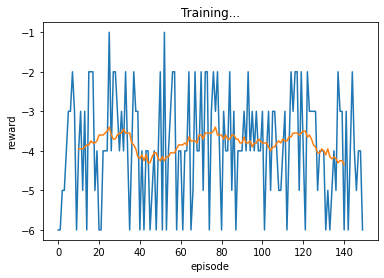

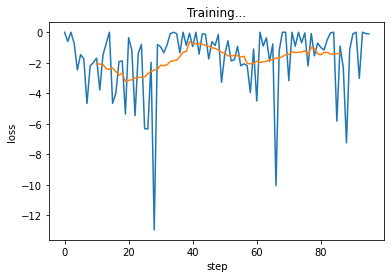

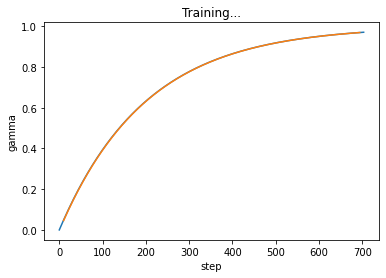

In [28]:
plot_all(*run_experiment(
    model=ModelConfig(name='monte'),
    num_episodes=150,
    training=TrainConfig(optimizer='sgd', lr=0.1, batch_size=32, train_interval=32, clear_memory=True),
    seed=1
    ))

In [ ]:
plot_all(*run_experiment(
    model=ModelConfig(name='nn'),
    num_episodes=150,
    training=TrainConfig(optimizer='adam', lr=0.009, batch_size=32, train_interval=32, clear_memory=True)
    ))

In [ ]:
plot_all(*run_experiment(
    model=ModelConfig(name='nn'),
    num_episodes=300,
    training=TrainConfig(optimizer='adam', lr=0.03, batch_size=64, train_interval=64, clear_memory=True)
    ))